# EnergyFaultDetector @ District Heating

This notebook shows how to apply the EnergyFaultDetector on the PreDist dataset (available on [zenodo](https://doi.org/10.5281/zenodo.17522254)) and how to reproduce results from the accompanying paper (preprint available on [arXiv](https://doi.org/10.48550/arXiv.2511.14791)).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score, precision_score, recall_score, ConfusionMatrixDisplay

from predist_utils import train_or_get_model, find_optimal_threshold, get_arcana_importances, calculate_earliness

from energy_fault_detector.evaluation import PreDistDataset
from energy_fault_detector import Config
from energy_fault_detector.utils.visualisation import plot_reconstruction
from energy_fault_detector.utils.analysis import create_events

### Load the PreDist dataset

In [2]:
dataset = PreDistDataset('./predist_data', download_dataset=False)
# Check events for manufacturer 1
dataset.events[1]

,substation ID,Report date,Problem EN,Event description EN,Possible anomaly start,Possible anomaly end,Training start,Training end,efd_possible,Fault label,Monitoring potential,Event type,Event end,Event start
Event ID,,,,,,,,,,,,,,
1,10,2014-05-04 14:44:00,no DHW,No hot water. Actuator (DHW system) replaced.,2014-05-03 16:00:00,2014-05-05 04:00:00,2012-03-28 09:00:00,2014-04-20 14:44:00,True,Motorised control valve (primary side): Actuat...,3.4,anomaly,2014-05-04 14:44:00,NaT
3,12,2015-12-01 10:56:00,no heat,Control parameters updated.,2015-11-29 12:00:00,2015-12-02 10:56:00,2015-03-01 00:00:00,2015-11-17 10:56:00,True,Control unit: Incorrect parameterisation,4,anomaly,2015-12-01 10:56:00,NaT
5,11,2018-11-23 08:30:00,no heat,Pump settings updated.,NaT,2018-11-26 09:56:59,2015-02-20 14:00:00,2018-11-09 08:30:00,True,Failure of the heating circuit pump,3.8,anomaly,2018-11-23 08:30:00,NaT
6,21,2016-12-06 13:12:00,not enough heat,The heaters are not getting warm enough. Suppl...,NaT,2016-12-07 13:12:00,2015-11-30 09:00:00,2016-11-22 13:12:00,True,Control unit: Incorrect parameterisation,4,anomaly,2016-12-06 13:12:00,NaT
7,26,2020-06-13 10:38:00,no DHW,The needle valve was closed. Readjusted.,2020-06-12 12:00:00,2020-06-14 10:38:00,2018-10-18 13:00:00,2020-05-30 10:38:00,True,Incorrect setting of the differential pressure...,3.1,anomaly,2020-06-13 10:38:00,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,5,NaT,NaN,NaN,NaT,NaT,2016-02-29 00:00:00,2018-02-28 00:00:00,NaN,NaN,NaN,normal,2018-03-07 00:00:00,2018-02-28
59,22,NaT,NaN,NaN,NaT,NaT,2018-06-21 10:00:00,2019-01-31 00:00:00,NaN,NaN,NaN,normal,2019-02-07 00:00:00,2019-01-31
61,14,NaT,NaN,NaN,NaT,NaT,2017-12-04 00:00:00,2019-12-05 00:00:00,NaN,NaN,NaN,normal,2019-12-12 00:00:00,2019-12-05


### Create or load models (uses optimized configs)

Models defined are:
 - the default autoencoder,
 - conditional autoencoder with day-of-week and hour-of-day time features, and
 - day-of-year autoencoder with day-of-week, hour-of-day and day-of-year time features.

The code size (bottleneck, latent dimension) of the autoencoder is represented as fraction of the input dimension.

In [3]:
model_configs = {
    1: {
        'config_files': {
            'Default AE': './configs/m1_default_ae.yaml',
            'Conditional AE': './configs/m1_cond_ae.yaml',
            'Day-of-year AE': './configs/m1_doy_ae.yaml'
        },
        'bottleneck': 0.65,
    },
    2: {
        'config_files': {
            'Default AE': './configs/m2_default_ae.yaml',
            'Conditional AE': './configs/m2_cond_ae.yaml',
            'Day-of-year AE': './configs/m2_doy_ae.yaml'
        },
        'bottleneck': 0.25
    }
}

time_features = {
    'Default AE': [],
    'Conditional AE': ['hour_of_day', 'day_of_week'],
    'Day-of-year AE': ['hour_of_day', 'day_of_week', 'day_of_year'],
}

# Model file exists, load the model
load_from_file = True

In [4]:
# Create or load model, predict and collect results for all events
from joblib import Parallel, delayed


# Select which dataset(s) and model configs to test:
manufacturers = [1, 2]
models = ['Default AE', 'Conditional AE', 'Day-of-year AE']

results = {}
for manufacturer in manufacturers:
    results[manufacturer] = {}
    for model_name, config_file in model_configs[manufacturer]['config_files'].items():
        if model_name not in models:
            continue

        # get configuration and time features
        conf = Config(config_file)

        # Prepare parameters for parallel execution
        bottleneck_ratio = model_configs[manufacturer]['bottleneck']
        events_to_process = dataset.events[manufacturer].index

        # Run parallel over events
        # n_jobs=-1 uses all CPU cores. Adjust if memory is an issue.
        parallel_results = Parallel(n_jobs=-1, verbose=10)(
            delayed(train_or_get_model)(
                event_id, dataset, manufacturer, model_name,
                conf, bottleneck_ratio, load_from_file, time_features[model_name]
            ) for event_id in events_to_process
        )

        # Create the results dictionary
        results[manufacturer][model_name] = dict(parallel_results)

[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done   5 out of  64 | elapsed:    7.9s remaining:  1.5min
[Parallel(n_jobs=100)]: Done  12 out of  64 | elapsed:    9.0s remaining:   38.8s
[Parallel(n_jobs=100)]: Done  19 out of  64 | elapsed:    9.3s remaining:   22.0s
[Parallel(n_jobs=100)]: Done  26 out of  64 | elapsed:    9.5s remaining:   14.0s
[Parallel(n_jobs=100)]: Done  33 out of  64 | elapsed:    9.9s remaining:    9.3s
[Parallel(n_jobs=100)]: Done  40 out of  64 | elapsed:   10.1s remaining:    6.0s
[Parallel(n_jobs=100)]: Done  47 out of  64 | elapsed:   10.1s remaining:    3.7s
[Parallel(n_jobs=100)]: Done  54 out of  64 | elapsed:   10.1s remaining:    1.9s
[Parallel(n_jobs=100)]: Done  61 out of  64 | elapsed:   10.2s remaining:    0.5s
[Parallel(n_jobs=100)]: Done  64 out of  64 | elapsed:   10.6s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done   5

### Find optimal criticality threshold based on the reliability score
Calculate max criticality before the report timestamp and optimize criticality threshold. We use cross-validation to find the criticality threshold to prevent overfitting, so the model will generalize better to unseen data.

In [5]:
max_criticality_results = {}
criticality_thresholds = {}
predicted_anomalies = {}
true_anomalies = {}

for manufacturer in results.keys():
    # prepare result dictionaries
    max_criticality_results[manufacturer] = {}
    criticality_thresholds[manufacturer] = {}
    predicted_anomalies[manufacturer] = {}

    # save true anomalies for easy access later
    true_anomalies[manufacturer] = (dataset.events[manufacturer]['Event type'] == 'anomaly').astype(int)

    for model_name, results_dict in results[manufacturer].items():

        # calculate max criticality for each event
        max_criticality_list = []
        for event_id, prediction in results_dict.items():
            event_row = dataset.events[manufacturer].loc[event_id]
            max_criticality = prediction.criticality().loc[:event_row['Report date']].max()
            max_criticality_list += [(event_id, max_criticality)]

        # Transform results to pandas series with max criticality with event id as index
        c = pd.DataFrame(max_criticality_list, columns=['event_id', 'max_criticality'])
        c = c.set_index('event_id')['max_criticality']
        max_criticality_results[manufacturer][model_name] = c

        criticality_threshold, _ = find_optimal_threshold(
            true_anomalies=true_anomalies[manufacturer],
            max_criticalities=max_criticality_results[manufacturer][model_name],
        )
        criticality_thresholds[manufacturer][model_name] = criticality_threshold
        predicted_anomalies[manufacturer][model_name] = c > criticality_threshold

### Final results (reliability and eventwise precision+recall)

Note: The trained models may not reproduce the exact results reported in the paper due to random initialization, hardware differences, and random seeds. In practice, it is advisable to train each model 5–10 times and select the best-performing run for the target application.

Manufacturer m1
Model Default AE:
Reliability: 0.87, Precision: 0.95, Recall: 0.66, Earliness: 0.59
Model Conditional AE:
Reliability: 0.90, Precision: 1.00, Recall: 0.66, Earliness: 0.60
Model Day-of-year AE:
Reliability: 0.92, Precision: 1.00, Recall: 0.69, Earliness: 0.65
Manufacturer m2
Model Default AE:
Reliability: 0.64, Precision: 0.77, Recall: 0.38, Earliness: 0.35
Model Conditional AE:
Reliability: 0.74, Precision: 0.82, Recall: 0.54, Earliness: 0.52
Model Day-of-year AE:
Reliability: 0.73, Precision: 0.86, Recall: 0.46, Earliness: 0.44


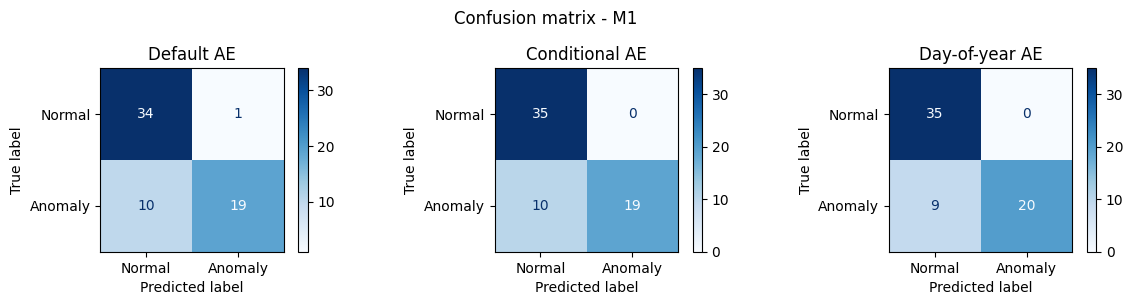

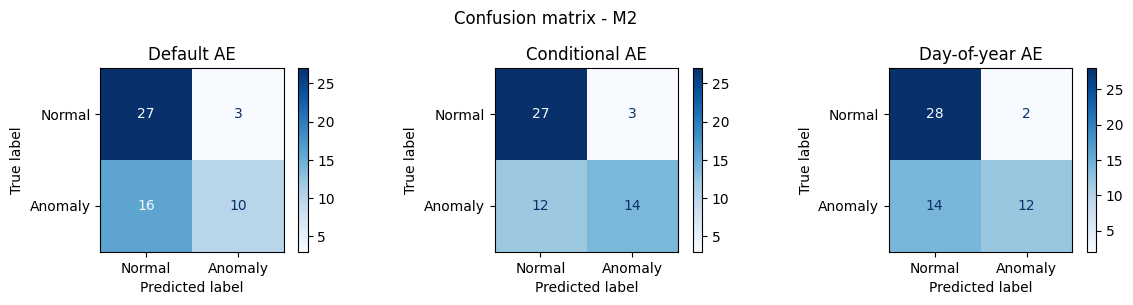

In [6]:
for manufacturer in results.keys():
    print(f'Manufacturer m{manufacturer}')

    fig, ax = plt.subplots(1, 3, figsize=(12, 3))
    
    for model_name, ax_ in zip(results[manufacturer].keys(), ax):
        print(f'Model {model_name}:')

        reliability = fbeta_score(
            true_anomalies[manufacturer], predicted_anomalies[manufacturer][model_name],
            beta=0.5
        )
        precision = precision_score(
            true_anomalies[manufacturer], predicted_anomalies[manufacturer][model_name]
        )
        recall = recall_score(
            true_anomalies[manufacturer], predicted_anomalies[manufacturer][model_name]
        )

        # Average earliness score over reports
        earliness_scores = []
        for event_id, predictions in results[manufacturer][model_name].items():
            if dataset.events[manufacturer].loc[event_id]['Event type'] == 'anomaly':
                criticality = predictions.criticality()
                detection_time, earliness = calculate_earliness(
                    criticality_threshold=criticality_thresholds[manufacturer][model_name],
                    report_ts=dataset.events[manufacturer].loc[event_id]['Report date'],
                    criticality=criticality
                )
                earliness_scores.append(earliness)
        avg_earliness = sum(earliness_scores) / len(earliness_scores)

        print(f'Reliability: {reliability:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, Earliness: {avg_earliness:.2f}')

        disp = ConfusionMatrixDisplay.from_predictions(
            y_true=true_anomalies[manufacturer], y_pred=predicted_anomalies[manufacturer][model_name],
            cmap='Blues',
            labels=[False, True],
            display_labels=['Normal', 'Anomaly'],
            ax=ax_
        )
        ax_.set_title(model_name)
    
    fig.suptitle(f'Confusion matrix - M{manufacturer}')
    plt.tight_layout()

### Visualise results

Here we show how to visualise results for a specific event and model.

For the event chosen, 49 of manufacturer 1, the customer called because of lack of hot water. It turned out to be an operating error where the DHW controller was set to night mode, leading to a very low setpoint for the DHW storage temperatures

In [7]:
# Choose event and model to plot results for
manufacturer = 1
model_name = 'Conditional AE'
event_id = 49
report_date = dataset.events[manufacturer].loc[event_id]['Report date']

# Event details
dataset.events[manufacturer].loc[event_id]

substation ID                                                            18
Report date                                             2019-05-04 07:19:00
Problem EN                                                           no DHW
Event description EN      The DHW controller was set to night mode. Rese...
Possible anomaly start                                  2019-05-03 11:00:00
Possible anomaly end                                    2019-05-05 07:19:00
Training start                                          2016-12-16 10:00:00
Training end                                            2019-04-20 07:19:00
efd_possible                                                           True
Fault label                        Control unit: Incorrect parameterisation
Monitoring potential                                                      4
Event type                                                          anomaly
Event end                                               2019-05-04 07:19:00
Event start 

#### Criticality

Plot the criticality and the incident report timestamp.

Text(0.5, 0, '')

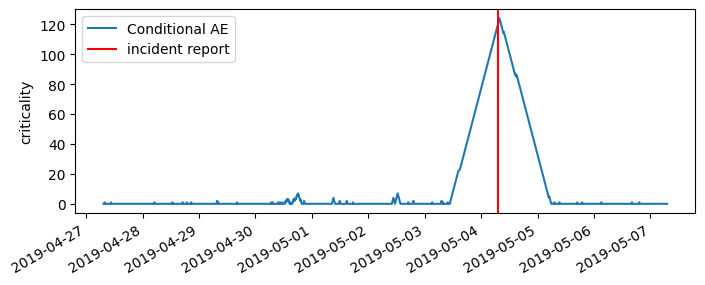

In [8]:
predictions = results[manufacturer][model_name][event_id]

fig, ax = plt.subplots(1, 1, figsize=(8,3))
crit = predictions.criticality()
crit.plot(ax=ax, label=model_name)

if pd.notna(report_date):
    ax.axvline(report_date, label='incident report', c='r', linestyle='-')

ax.legend(loc='upper left')
ax.set_ylabel('criticality')
ax.set_xlabel('')

#### ARCANA results

Here we first determine anomalous events detected by the model and then calculate the ARCANA feature importances for the longest detected anomaly event.
Afterward, we plot the top 3 features with the highest ARCANA feature importances.

In [9]:
test_data = dataset.get_event_data(manufacturer, event_id)['test_data']

# find longest detected anomaly event (continuous run of predicted anomalous timestamps)
anomaly_events, _ = create_events(
    test_data,
    predictions.predicted_anomalies,
    min_event_length=12
)
longest_anomaly_event = anomaly_events[anomaly_events['duration'] == anomaly_events['duration'].max()].iloc[0]

# Calculate ARCANA feature importances
top_features = get_arcana_importances(manufacturer, event_id, model_name, test_data.loc[longest_anomaly_event['start']:report_date])

top_features

s_dhw_supply_temperature_setpoint    0.268510
s_hc1_supply_temperature_setpoint    0.215204
p_hc1_return_temperature             0.118098
p_net_supply_temperature             0.110434
outdoor_temperature                  0.082548
s_dhw_lower_storage_temperature      0.058807
s_hc1_supply_temperature             0.058639
s_dhw_supply_temperature             0.029270
p_net_meter_flow                     0.024234
p_net_return_temperature             0.023280
s_dhw_upper_storage_temperature      0.006409
p_net_meter_heat_power               0.004566
dtype: float32

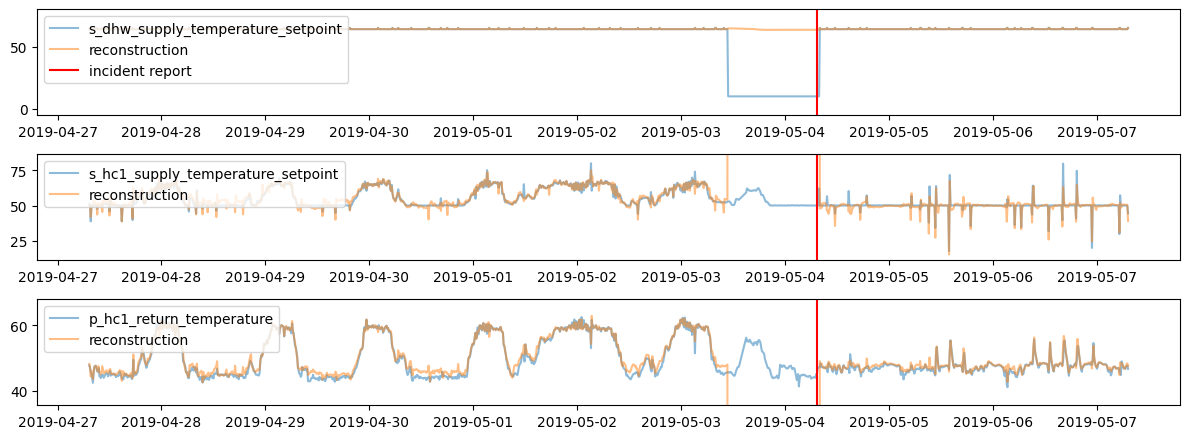

In [10]:
# Plot the reconstruction of the top 3
fig, ax = plot_reconstruction(test_data, predictions.reconstruction, top_features.index[:3].to_list())

for ax_ in ax:
    ax_.axvline(report_date, label='incident report', color='r', linestyle='-')

ax[0].legend(loc='upper left')